In [3]:
!pip install mediapipe==0.10.14 opencv-python matplotlib numpy


In [28]:
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import mediapipe as mp

# ---------- helpers ----------
def calc_angle(a,b,c):
    a,b,c = np.array(a,float), np.array(b,float), np.array(c,float)
    ba, bc = a-b, c-b
    na, nc = np.linalg.norm(ba), np.linalg.norm(bc)
    if na<1e-9 or nc<1e-9: return np.nan
    cosv = np.dot(ba,bc)/(na*nc)
    return np.degrees(np.arccos(np.clip(cosv, -1.0, 1.0)))

def moving_average_same(x, k=9):
    k = max(3, int(k)|1)
    xp = np.pad(x, (k//2, k//2), mode='edge')
    return np.convolve(xp, np.ones(k)/k, mode='valid')

def zero_phase_ma(x, k=9):
    y1 = moving_average_same(x, k)
    return moving_average_same(y1[::-1], k)[::-1]

def fill_small_gaps(x, fps, max_gap_s=0.30):
    x = np.asarray(x, float).copy()
    n = len(x)
    isnan = ~np.isfinite(x)
    if not isnan.any(): return x
    max_gap = int(round(max_gap_s * fps))
    i = 0
    while i < n:
        if np.isfinite(x[i]): i += 1; continue
        start = i
        while i < n and not np.isfinite(x[i]): i += 1
        end = i-1
        run = end - start + 1
        if run <= max_gap:
            L, R = start-1, end+1
            if 0<=L<n and 0<=R<n and np.isfinite(x[L]) and np.isfinite(x[R]):
                x[start:end+1] = np.linspace(x[L], x[R], run+2)[1:-1]
    return x

def find_extrema_prom(y, fps, min_prominence=5.0, min_distance_s=0.4):
    y = np.asarray(y, float)
    n = len(y)
    if n < 3: return np.array([], int), np.array([], int)
    dy = np.sign(np.diff(y, prepend=y[0]))
    zc = np.diff(dy, prepend=dy[0])
    cand_peaks   = np.where(zc == -2)[0]
    cand_troughs = np.where(zc ==  2)[0]
    min_dist = max(1, int(round(min_distance_s * fps)))

    def keep(cands, is_peak=True):
        kept, last = [], -10**9
        for i in cands:
            L = max(0, i - min_dist); R = min(n-1, i + min_dist)
            prom = (y[i] - np.min(y[i:R+1])) if is_peak else (np.max(y[L:i+1]) - y[i])
            if (i - last) >= min_dist and prom >= min_prominence:
                kept.append(i); last = i
        return np.array(kept, int)

    return keep(cand_peaks, True), keep(cand_troughs, False)

def merge_close(idx_a, idx_b, tol_frames):
    """Union of two index sets; merge points closer than tol_frames."""
    a = np.unique(np.concatenate([idx_a, idx_b])).astype(int)
    if len(a) == 0: return a
    merged = [a[0]]
    for i in a[1:]:
        if i - merged[-1] <= tol_frames:
            # keep the later one (closer to actual switch for velocity)
            merged[-1] = i
        else:
            merged.append(i)
    return np.array(merged, int)

def velocity_zero_crossings(y, fps, smooth_k=9, vel_deadband=0.0):
    """Return indices where angular velocity crosses -→+ (bottoms)."""
    dt = 1.0 / fps
    y_sm = zero_phase_ma(y, k=smooth_k)
    v = np.gradient(y_sm, dt)
    # optional extra smoothing of v for stability
    v_sm = zero_phase_ma(v, k=max(3, smooth_k//2*2+1))
    sign = np.sign(v_sm)
    zc = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0] + 1
    if vel_deadband > 0:
        # keep only where speed change magnitude is meaningful
        dv = np.abs(np.diff(v_sm))
        keep = []
        for i in zc:
            if i-1 >= 0 and i-1 < len(dv) and dv[i-1] >= vel_deadband:
                keep.append(i)
        zc = np.array(keep, int)
    return zc

def enforce_min_concentric(reps, y, t, fps, troughs=None,
                           min_concentric_s=0.6, max_concentric_s=3.0, prominence_deg=5.0):
    new = []
    n = len(y)
    for (p1,b,p2) in reps:
        start = b + int(round(min_concentric_s * fps))
        if start >= n: new.append((p1,b,p2)); continue
        if troughs is not None and len(troughs[troughs > b]):
            next_b = int(troughs[troughs > b][0]); end = min(n-1, next_b-1)
        else:
            end = min(n-1, b + int(round(max_concentric_s * fps)))
        if end <= start: new.append((p1,b,p2)); continue
        p2n = start + int(np.argmax(y[start:end+1]))
        if y[p2n] - y[b] < prominence_deg and end > b+1:
            p2n = (b+1) + int(np.argmax(y[b+1:end+1]))
        new.append((p1,b,p2n))
    return new

# ---------- main ----------
def analyze_squat_v3(
    video_path,
    side="RIGHT",
    k_smooth=9,
    min_prominence=5.0,
    min_distance_s=0.4,
    min_concentric_s=0.6,
    max_gap_s=0.30,
    visibility_thresh=0.5,
    time_window=None,
    save_csv=None,
    plot=True
):
    mp_pose = mp.solutions.pose
    cap = cv2.VideoCapture(r"C:\Users\graka\Downloads\Goblet Squat Tutorial  Goblet Squat Form Side View - Kettlebell Kings (480p, h264, youtube).mp4")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    HIP  = getattr(mp_pose.PoseLandmark, f"{side.upper()}_HIP").value
    KNEE = getattr(mp_pose.PoseLandmark, f"{side.upper()}_KNEE").value
    ANK  = getattr(mp_pose.PoseLandmark, f"{side.upper()}_ANKLE").value

    angles = []
    with mp_pose.Pose(static_image_mode=False, model_complexity=1,
                      smooth_landmarks=True, min_detection_confidence=0.3,
                      min_tracking_confidence=0.3) as pose:
        while cap.isOpened():
            ok, frame = cap.read()
            if not ok: break
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img.flags.writeable = False
            res = pose.process(img)
            if res.pose_landmarks:
                lm = res.pose_landmarks.landmark
                vis = min(lm[HIP].visibility, lm[KNEE].visibility, lm[ANK].visibility)
                if vis < visibility_thresh:
                    angles.append(np.nan); continue
                hip  = [lm[HIP].x,  lm[HIP].y]
                knee = [lm[KNEE].x, lm[KNEE].y]
                ank  = [lm[ANK].x,  lm[ANK].y]
                angles.append(calc_angle(hip, knee, ank))
            else:
                angles.append(np.nan)
    cap.release()

    angles = np.array(angles, float)
    t = np.arange(len(angles)) / fps

    if time_window is not None:
        t0,t1 = time_window
        m = (t>=t0) & (t<=t1)
        angles, t = angles[m], t[m]

    # clean + zero-phase smooth
    angles_filled = fill_small_gaps(angles, fps=fps, max_gap_s=max_gap_s)
    if not np.isfinite(angles_filled).any():
        return pd.DataFrame(), {"fps": fps, "n_frames": len(angles), "note": "all NaN"}, []

    y = zero_phase_ma(angles_filled, k=k_smooth)
    if not np.isfinite(y).all():
        idx = np.arange(len(y)); m = np.isfinite(y); y = np.interp(idx, idx[m], y[m])
    t = t[:len(y)]

    # extrema by prominence
    peaks, troughs = find_extrema_prom(y, fps, min_prominence=min_prominence, min_distance_s=min_distance_s)

    # add bottoms by velocity zero-crossings, then merge
    vel_eps = 0.15 * np.nanstd(np.gradient(y, 1.0/fps))  # adaptive, small
    bottoms_vel = velocity_zero_crossings(y, fps, smooth_k=max(3, k_smooth//2*2+1), vel_deadband=vel_eps)
    tol = max(1, int(0.10 * fps))  # merge within 0.10 s
    bottoms = merge_close(troughs, bottoms_vel, tol_frames=tol)
    bottoms = np.sort(bottoms)

    # build reps using bottoms (preferred), with edge handling
    reps = []
    for b in bottoms:
        prev_p = peaks[peaks < b]
        next_p = peaks[peaks > b]
        if len(prev_p) and len(next_p):
            p1, p2 = prev_p[-1], next_p[0]
            if (p2 - p1) >= int(0.4*fps): reps.append((p1,b,p2))
        else:
            # edge cases
            if len(prev_p)==0 and len(next_p):
                p1, p2 = 0, next_p[0]
                if (p2 - p1) >= int(0.3*fps): reps.append((p1,b,p2))
            elif len(prev_p) and len(next_p)==0:
                p1, p2 = prev_p[-1], len(y)-1
                if (p2 - p1) >= int(0.3*fps): reps.append((p1,b,p2))

    # fallback: trough-to-trough segmentation (helps when a peak is missed)
    if len(reps) + 1 < len(bottoms):
        for i in range(len(bottoms)-1):
            b1, b2 = bottoms[i], bottoms[i+1]
            # start peak as best max in [b1 - 0.6s, b1) and end peak as best max in (b2, b2 + 0.6s]
            pad = int(0.6 * fps)
            Ls = max(0, b1 - pad); Rs = b1
            Le = b2; Re = min(len(y)-1, b2 + pad)
            if Rs > Ls:
                p1 = Ls + int(np.argmax(y[Ls:Rs]))
            else:
                p1 = max(0, b1 - 1)
            if Re > Le:
                p2 = Le + int(np.argmax(y[Le:Re+1]))
            else:
                p2 = min(len(y)-1, b2 + 1)
            if p2 - p1 >= int(0.3*fps):
                reps.append((p1, b1, p2))

        # deduplicate overlapping reps
        reps = sorted(set(reps), key=lambda r: (r[1], r[0], r[2]))

    # enforce minimum concentric duration
    reps = enforce_min_concentric(reps, y, t, fps, troughs=bottoms,
                                  min_concentric_s=min_concentric_s,
                                  prominence_deg=min_prominence)

    # per-rep table
    rows = []
    for i,(p1,b,p2) in enumerate(reps, start=1):
        start_t, bottom_t, end_t = t[p1], t[b], t[p2]
        start_a, min_a, end_a = y[p1], y[b], y[p2]
        rom = max(start_a, end_a) - min_a
        rows.append({
            "rep": i,
            "start_s": round(float(start_t),3),
            "bottom_s": round(float(bottom_t),3),
            "end_s": round(float(end_t),3),
            "min_angle_deg": round(float(min_a),1),
            "ROM_deg": round(float(rom),1),
            "duration_s": round(float(end_t-start_t),3),
            "concentric_s": round(float(end_t-bottom_t),3),
        })
    df_reps = pd.DataFrame(rows)

    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(t, y, label=f"{side.title()} knee (smoothed)")
        if len(peaks):   plt.scatter(t[peaks],   y[peaks],   marker='^', label='Peaks')
        if len(troughs): plt.scatter(t[troughs], y[troughs], marker='v', label='Troughs')
        if len(bottoms): plt.scatter(t[bottoms], y[bottoms], marker='x', label='Bottoms (merged)')
        for (p1,b,p2) in reps:
            plt.axvspan(t[p1], t[p2], alpha=0.12)
        plt.xlabel("Time (s)"); plt.ylabel("Angle (deg)")
        plt.title(f"Reps detected: {len(df_reps)}")
        plt.legend(); plt.show()

    if save_csv: df_reps.to_csv(save_csv, index=False)

    summary = {
        "fps": round(float(fps),2),
        "n_frames": int(len(y)),
        "reps_detected": int(len(df_reps)),
        "k_smooth": int(k_smooth),
        "min_prominence_deg": float(min_prominence),
        "min_distance_s": float(min_distance_s),
        "min_concentric_s": float(min_concentric_s),
        "max_gap_s": float(max_gap_s),
        "bottoms_found": int(len(bottoms)),
        "peaks_found": int(len(peaks))
    }
    return df_reps, summary, {"peaks": peaks, "troughs": troughs, "bottoms": bottoms, "y": y, "t": t}


C:\Users\graka\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


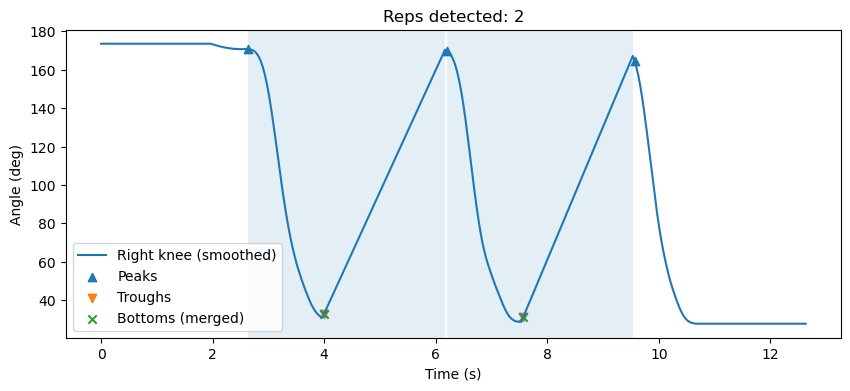

{'fps': 30.0,
 'n_frames': 380,
 'reps_detected': 2,
 'k_smooth': 9,
 'min_prominence_deg': 5.0,
 'min_distance_s': 0.4,
 'min_concentric_s': 0.6,
 'max_gap_s': 0.3,
 'bottoms_found': 2,
 'peaks_found': 3}

,rep,start_s,bottom_s,end_s,min_angle_deg,ROM_deg,duration_s,concentric_s
0,1,2.633,4.000,6.167,33.1,137.7,3.533,2.167
1,2,6.200,7.567,9.533,31.0,138.9,3.333,1.967


In [30]:
df_reps, summary, diag = analyze_squat_v3(
    r"C:\Users\graka\Downloads\Goblet Squat Tutorial  Goblet Squat Form Side View - Kettlebell Kings (480p, h264, youtube).mp4",
    side="RIGHT",
    k_smooth=9,
    min_prominence=5.0,
    min_distance_s=0.4,
    min_concentric_s=0.6,
    max_gap_s=0.30,
    time_window=(0, 20),   # or None
    plot=True
)

display(summary)
display(df_reps)

